In [1]:
import os.path
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = 'multiplex_embeddings_data'
datasets_layer_description = {  # {dataset: [layer_1 description, layer_2 description, ...]}
    'Air_Train': [
        'Air network',
        'Train network',
    ],
    'arXiv': [
        'physics.bioph category',
        'cond-mat.disnn category',
        'physics.soc-ph',
        'physics.data-an category',
        'math.OC category',
        'cond-mat.stat-mech category',
        'q-bio.MN category',
        'cs.SI category',
    ],
    'C. Elegans Connectomme': [
        'Electric',
        'Chemical Monadic',
        'Chemical Polyadic',
    ],
    'Drosophila Melanogaster': [  # meh
        'suppressive genetic interaction',
        'additive genetic interaction',
    ],
    'Human Brain': [
        'structural brain network',
        'functional brain network',
    ],
    'IPv4_IPv6 Internet': [  # meh
        'IPv4 topology',
        'IPv6 topology',
    ],
    'Physicians': [
        'advice',
        'discussion',
        'friendship',
    ],
    'Rattus': [  # meh
        'physical association',
        'direct interaction',
    ],
    'SacchPomb': [
        'direct interaction',
        'colocalization',
        'physical association',
        'synthetic genetic interaction',
        'association',
    ],
}
dataset_names = list(datasets_layer_description.keys())
datasets_layer_description, dataset_names

({'Air_Train': ['Air network', 'Train network'],
  'arXiv': ['physics.bioph category',
   'cond-mat.disnn category',
   'physics.soc-ph',
   'physics.data-an category',
   'math.OC category',
   'cond-mat.stat-mech category',
   'q-bio.MN category',
   'cs.SI category'],
  'C. Elegans Connectomme': ['Electric',
   'Chemical Monadic',
   'Chemical Polyadic'],
  'Drosophila Melanogaster': ['suppressive genetic interaction',
   'additive genetic interaction'],
  'Human Brain': ['structural brain network', 'functional brain network'],
  'IPv4_IPv6 Internet': ['IPv4 topology', 'IPv6 topology'],
  'Physicians': ['advice', 'discussion', 'friendship'],
  'Rattus': ['physical association', 'direct interaction'],
  'SacchPomb': ['direct interaction',
   'colocalization',
   'physical association',
   'synthetic genetic interaction',
   'association']},
 ['Air_Train',
  'arXiv',
  'C. Elegans Connectomme',
  'Drosophila Melanogaster',
  'Human Brain',
  'IPv4_IPv6 Internet',
  'Physicians',
  'Ra

In [3]:
def load_dataset(dataset_name):
    print(f'Loading {dataset_name}')
    path = os.path.join(data_path, dataset_name)
    layer_paths = [os.path.join(path, f'l_{i}.txt')
                  for i in range(1, len(datasets_layer_description[dataset_name]) + 1)]
    G = [nx.read_edgelist(
            layer_path,
            create_using=nx.Graph,
            nodetype=int,
        ) for layer_path in layer_paths]
    print(*G, sep='\n')
    return G

In [11]:
def graph_stats(G):

    possible_nodes = set(G[0].nodes).union(
        *(set(g.nodes) for g in G[1:]),
    )
    outliers = [(n, i)
                for n in possible_nodes
                for i, g in enumerate(G)
                if n not in g]
    if outliers:
        print(f'{len(outliers)} nodes missing from layers: {outliers}')
        print('Fixing naively')

        for i, g in enumerate(G):
            g.add_nodes_from([n for n, il in outliers if il == i])
        
        # Check
        possible_nodes = set(G[0].nodes).union(
            *(set(g.nodes) for g in G[1:]),
        )
        outliers = [(n, i)
                    for n in possible_nodes
                    for i, g in enumerate(G)
                    if n not in g]
        if outliers:
            print(f'Still outliers: {outliers}')

    fig, ax = plt.subplots(nrows=len(G), ncols=3, figsize=(12, 3 * len(G)))
    for i, g in enumerate(G):

        print(f'Layer {i + 1}:')
        print(f'  Size: {len(g)}')
        print(f'  Edges: {len(g.edges)}')

        degree_sequence = sorted((d for _, d in g.degree), reverse=True)
        print(f'  Mean degree: {np.mean(degree_sequence)}')

        sorted_nodes = sorted(g.nodes)
        mn, mx = sorted_nodes[0], sorted_nodes[-1]
        if sorted_nodes == list(range(mn, mx + 1)):
            print(f'  Nodes are labeled through {mn}:{mx}')
        else:
            gaps = [n for n in range(mn, mx + 1) if n not in sorted_nodes]
            print(f'  Nodes are labeled through {mn}:{mx} with {len(gaps)} gaps {gaps}')
        
        ax[i, 0].set_title('Degree distribution')
        ax[i, 0].bar(*np.unique(degree_sequence, return_counts=True), width=.8)

        ax[i, 1].set_title('Degree distribution (log)')
        ax[i, 1].hist(degree_sequence, bins=np.logspace(np.log10(1), np.log10(len(g)), num=len(g)), rwidth=.8)
        # ax[i, 1].hist(degree_sequence, bins=len(g), rwidth=.8)
        ax[i, 1].set_xscale('log')
        ax[i, 1].set_yscale('log')
        # ax2.plot(np.exp(np.arange(1, np.log10(len(G)))), 1000 - 2.5 * np.exp(np.arange(1, np.log10(len(G)))))

        if len(g) < 1000:
            ax[i, 2].set_title('Graph')
            # gcc = g.subgraph(sorted(nx.connected_components(g), key=len, reverse=True)[0])
            pos = nx.spring_layout(g, seed=10396953)
            nx.draw_networkx_nodes(g, pos, ax=ax[i, 2], node_size=20)
            nx.draw_networkx_edges(g, pos, ax=ax[i, 2], alpha=.4, arrows=True)
            ax[i, 2].set_axis_off()

    fig.tight_layout()

In [12]:
def find_component(node, connected_components):
    for i, component in enumerate(connected_components):
        if node in component:
            return i
    raise ValueError(f'Component for node {node} not found')

In [13]:
def cascade_remove_links(Ga, Gb):

    keep_going = True
    while keep_going:
        keep_going = False

        clusters_a = list(nx.connected_components(Ga))
        for edge in Gb.edges():
            if find_component(edge[0], clusters_a) != find_component(edge[1], clusters_a):
                keep_going = True
                Gb.remove_edge(*edge)

        clusters_b = list(nx.connected_components(Gb))
        for edge in Ga.edges():
            if find_component(edge[0], clusters_b) != find_component(edge[1], clusters_b):
                keep_going = True
                Ga.remove_edge(*edge)
    
    return Ga, Gb

In [14]:
def articulation_points_multiplex(G1, G2):
    ap1 = set(nx.articulation_points(G1))
    ap2 = set(nx.articulation_points(G2))
    return ap1.union(ap2)

In [15]:
def max_comp(G):
    return max(nx.connected_components(G), key=len)

In [16]:
def remove_ap(G1, G2):
    G1, G2 = cascade_remove_links(G1, G2)

    gcc = max_comp(G1)
    gcc_size = len(gcc)

    G1.remove_nodes_from([n for n in G1 if n not in gcc])
    G2.remove_nodes_from([n for n in G2 if n not in gcc])

    art_points = articulation_points_multiplex(G1, G2)

    G1.remove_nodes_from(art_points)
    G2.remove_nodes_from(art_points)

    return G1, G2, art_points, gcc_size

In [23]:
experiment = dataset_names[7]
save_results = False

Loading Rattus
Graph with 2032 nodes and 2772 edges
Graph with 1010 nodes and 982 edges
2134 nodes missing from layers: [(1, 1), (2, 1), (3, 1), (4, 1), (5, 0), (9, 0), (14, 1), (15, 0), (16, 0), (17, 0), (19, 1), (20, 0), (21, 0), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (30, 1), (31, 1), (33, 1), (34, 1), (36, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (45, 1), (47, 1), (49, 1), (50, 1), (51, 1), (54, 0), (55, 0), (59, 0), (60, 1), (65, 1), (67, 0), (70, 0), (71, 1), (72, 1), (74, 1), (75, 1), (77, 1), (78, 0), (79, 0), (80, 1), (82, 0), (83, 0), (84, 0), (86, 0), (87, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (98, 1), (99, 1), (110, 0), (111, 0), (112, 0), (113, 0), (114, 0), (115, 0), (116, 0), (118, 0), (119, 0), (123, 0), (124, 0), (125, 0), (126, 0), (129, 0), (130, 0), (136, 0), (138, 1), (140, 0), (141, 0), (142, 0), (143, 0), (144, 0), (147, 0), (150, 1), (151, 1), (152, 1), (153, 1), (154, 1), (156, 1), (

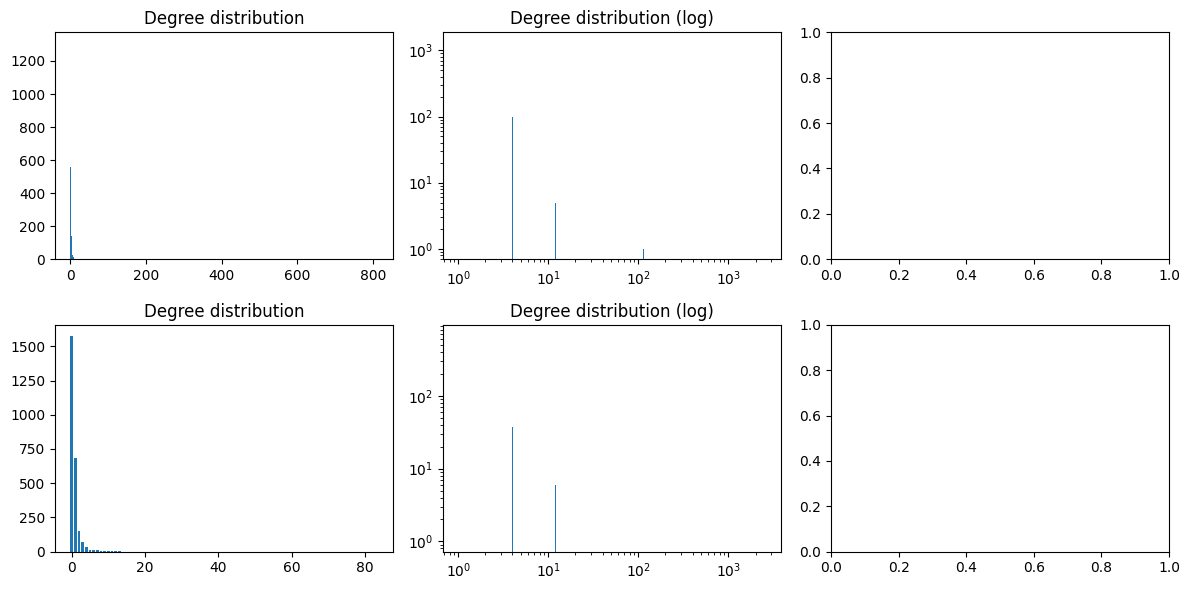

In [24]:
G = load_dataset(experiment)
graph_stats(G)

In [193]:
*G, ap, gcc_size = remove_ap(*G)
G, ap, len(ap), gcc_size

([<networkx.classes.graph.Graph at 0x21479b35f90>,
 {8,
  44,
  46,
  73,
  76,
  102,
  103,
  106,
  131,
  149,
  169,
  180,
  182,
  193,
  195,
  196,
  212,
  213,
  216,
  217,
  259,
  289,
  290,
  295,
  312,
  314,
  331,
  342,
  365,
  366,
  371,
  383,
  411,
  442,
  445,
  451,
  455,
  499,
  525,
  526,
  528,
  538,
  542,
  597,
  626,
  627,
  639,
  666,
  715,
  719,
  754,
  757,
  763,
  786,
  789,
  790,
  803,
  811,
  814,
  816,
  1005,
  1035,
  1107,
  1158,
  1162,
  1195,
  1216,
  1361,
  1365,
  1445,
  1454,
  1691,
  1722,
  1782,
  1783,
  1803,
  2206,
  2489},
 78,
 158)